In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob 
from skimage.io import imread
import cv2
from PIL import Image
from skimage.transform import resize
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import save_model

In [2]:
# Loading image paths
images = glob.glob('images2/*/*.jpg')
print(len(images)) # Total number of images
print(images[0])

152
images2\0\Anger.jpg


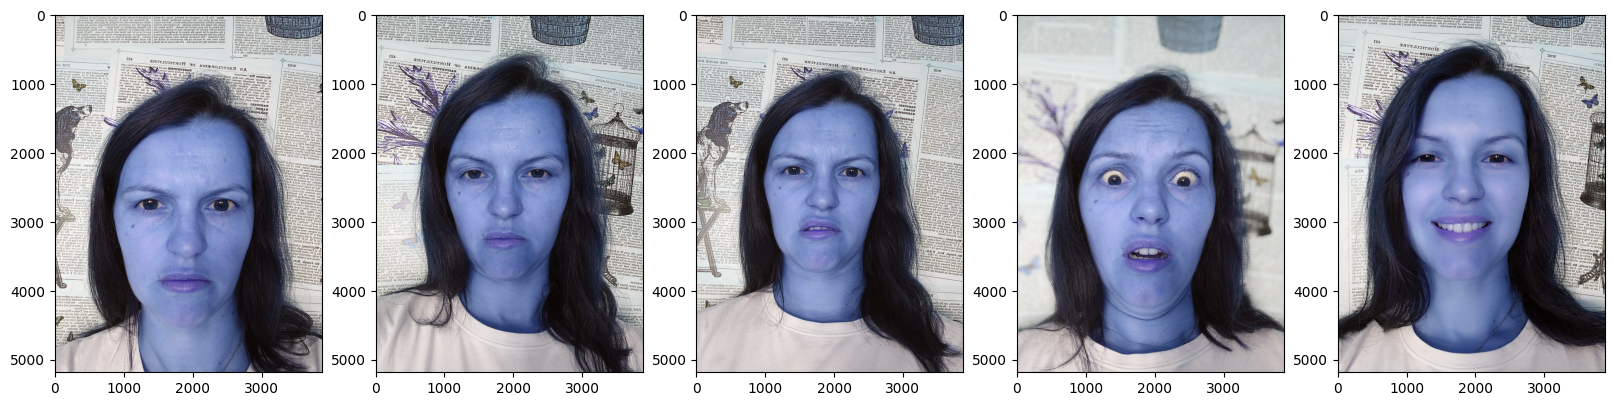

In [3]:
# Displaying some sample images
fig, axes = plt.subplots(1, 5, figsize=(20, 10))  
for i in range(5):
    img = cv2.imread(images[i])
    axes[i].imshow(img)      
plt.show()

In [4]:
# Creating a DataFrame for image paths and their respective emotions
image_data = pd.DataFrame(index=np.arange(0, len(images)), columns=['path', 'emotion'])
for i in range(len(images)):
    image_data.loc[i, 'path'] = images[i]
    image_data.loc[i, 'emotion'] = images[i][50:].replace(images[i][-4:], '')

In [5]:
image_data

path emotion
0        images2\0\Anger.jpg        
1     images2\0\Contempt.jpg        
2      images2\0\Disgust.jpg        
3         images2\0\Fear.jpg        
4        images2\0\Happy.jpg        
..                       ...     ...
147       images2\9\Fear.jpg        
148      images2\9\Happy.jpg        
149    images2\9\Neutral.jpg        
150        images2\9\Sad.jpg        
151  images2\9\Surprised.jpg        

[152 rows x 2 columns]

In [6]:
# Standardizing the emotion column values by removing unnecessary prefixes to ensure consistency in emotion labels.
image_data['emotion'] = image_data['emotion'].replace('/Surprised', 'Surprised')
image_data['emotion'] = image_data['emotion'].replace('/Happy', 'Happy')
image_data['emotion'] = image_data['emotion'].replace('/Sad', 'Sad')
image_data['emotion'] = image_data['emotion'].replace('/Anger', 'Anger')
image_data['emotion'] = image_data['emotion'].replace('/Neutral', 'Neutral')
image_data['emotion'] = image_data['emotion'].replace('/Fear', 'Fear')
image_data['emotion'] = image_data['emotion'].replace('/Contempt', 'Contempt')
image_data['emotion'] = image_data['emotion'].replace('/Disgust', 'Disgust')

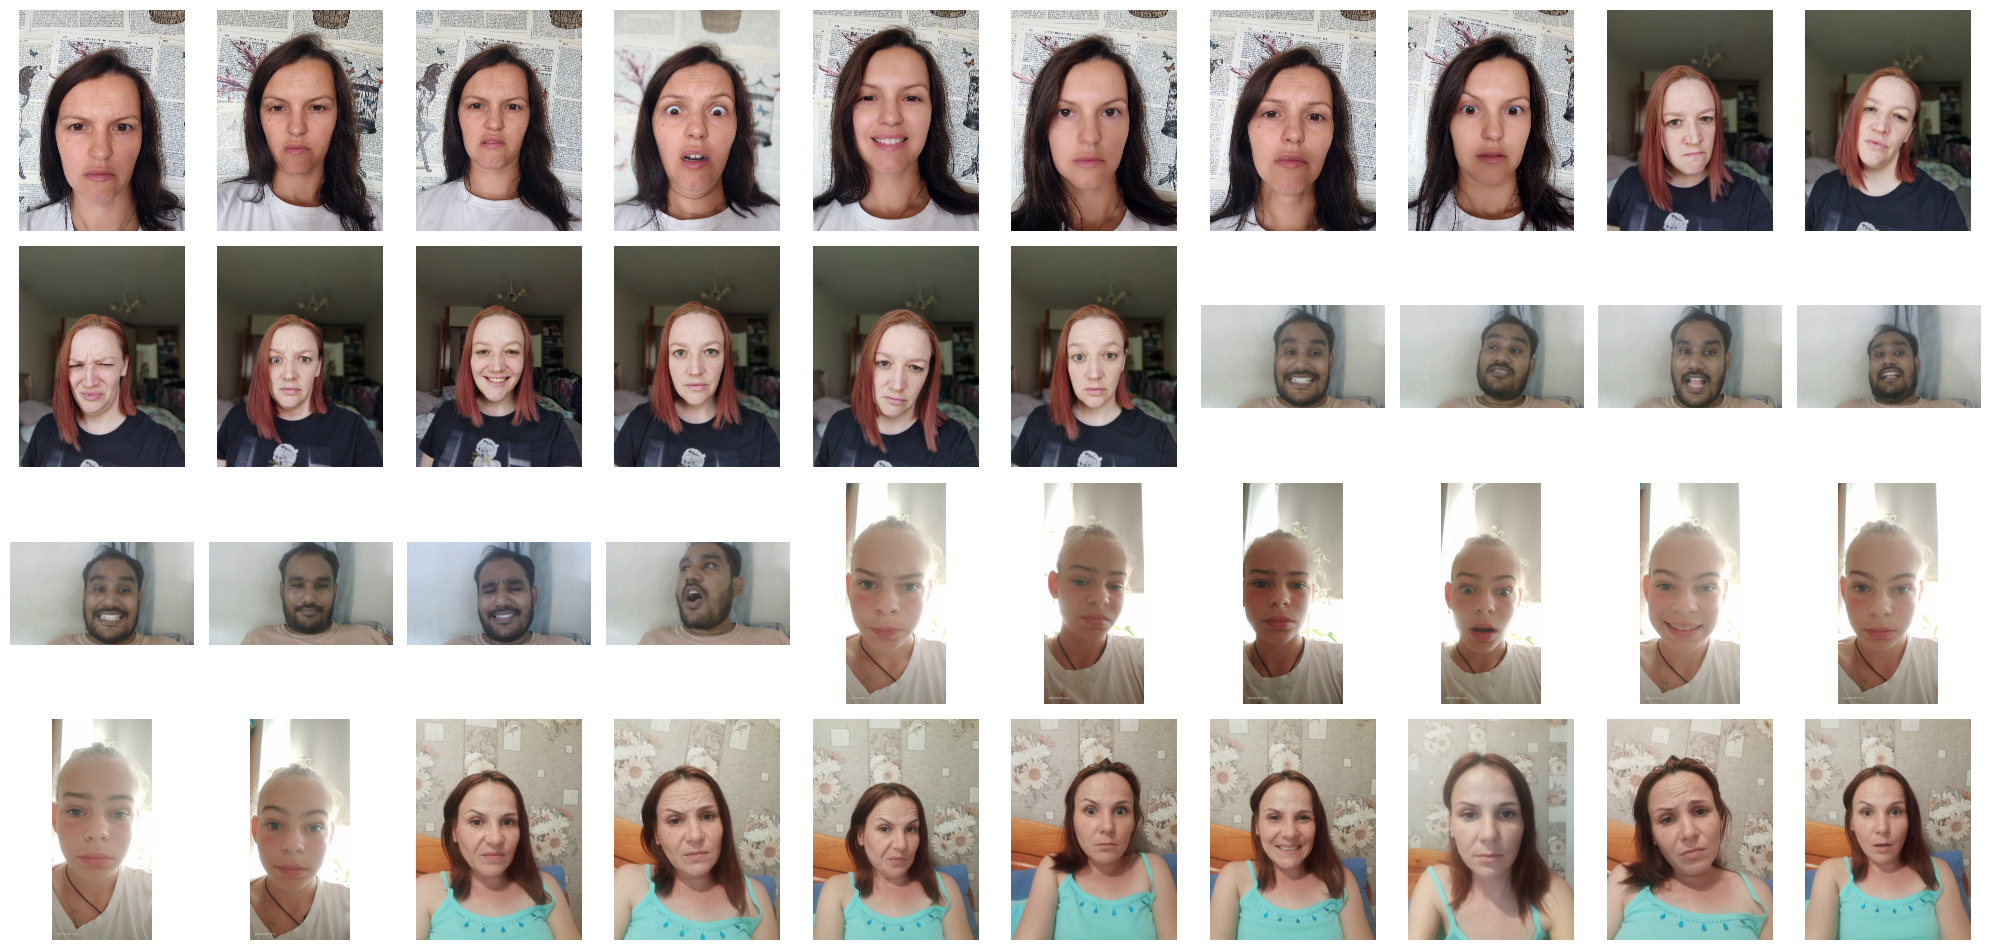

In [7]:
# Displaying a grid of 40 images (4 rows and 10 columns) with their corresponding emotion labels
fig, axes = plt.subplots(4, 10, figsize=(20, 10))
for i in range(4):
    for j in range(10):        
        image = imread(image_data.iloc[j + 10*i]["path"])
        axes[i, j].imshow(image)
        label = image_data.iloc[j + 10*i]["emotion"]
        axes[i, j].set_title(label, fontsize=8) 
        axes[i, j].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

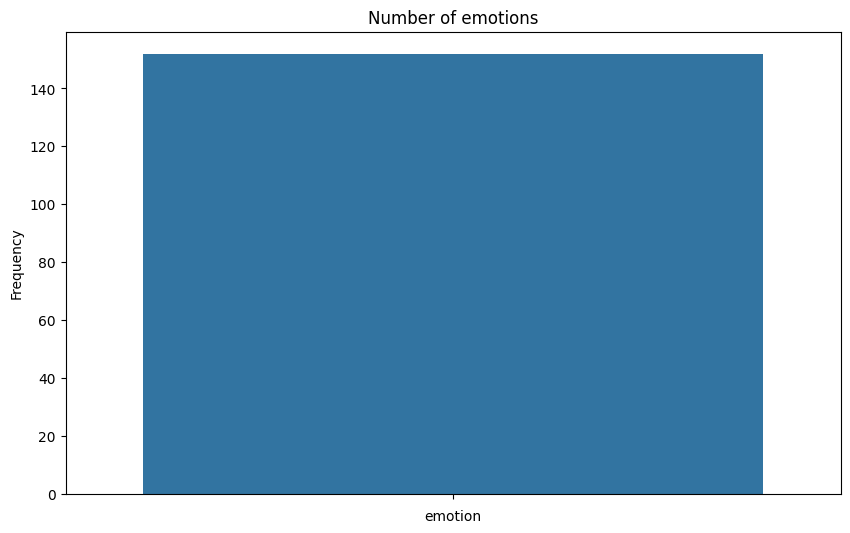

In [8]:
# Plotting the distribution of emotions to visualize the frequency of each emotion label in the dataset
plt.figure(figsize=(10, 6))
sns.barplot(x=image_data['emotion'].value_counts().index, y=image_data['emotion'].value_counts())
plt.title('Number of emotions')
plt.xlabel('emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [9]:
# Encoding the emotion labels as integers using LabelEncoder
label_encoder = LabelEncoder()
image_data['emotion'] = label_encoder.fit_transform(image_data['emotion'])

In [10]:
image_data

path  emotion
0        images2\0\Anger.jpg        0
1     images2\0\Contempt.jpg        0
2      images2\0\Disgust.jpg        0
3         images2\0\Fear.jpg        0
4        images2\0\Happy.jpg        0
..                       ...      ...
147       images2\9\Fear.jpg        0
148      images2\9\Happy.jpg        0
149    images2\9\Neutral.jpg        0
150        images2\9\Sad.jpg        0
151  images2\9\Surprised.jpg        0

[152 rows x 2 columns]

In [11]:
X = []
y = []
for feature, label in image_data.values:
    image = cv2.imread(feature)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
    X.append(image)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [12]:
# Print shape of input data (X) and output data (y)
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (152, 224, 224, 3)
Shape of y: (152,)


In [13]:
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest'       
)

In [14]:
# Applying augmentation to images
augmented_X = []
augmented_y = []
for i in range(len(X)):
    img = X[i].reshape((1, *X[i].shape))  
    label = y[i]
    for _ in range(50):  
        augmented = next(datagen.flow(img, batch_size=1))
        augmented_X.append(augmented[0])  
        augmented_y.append(label)        
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

In [15]:
# Combining original and augmented data
X = np.concatenate([X, augmented_X], axis=0)
y = np.concatenate([y, augmented_y], axis=0)

In [16]:
# Print shape of input data (X) and output data (y) after augmentation
print(X.shape)  
print(y.shape)

(7752, 224, 224, 3)
(7752,)


In [17]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [18]:
print(f'Length of Training Data: {len(X_train)}')
print(f'Length of Testing Data: {len(X_test)}')

Length of Training Data: 6201
Length of Testing Data: 1551


In [18]:
y_train = to_categorical(y_train, num_classes = 8)
y_test = to_categorical(y_test, num_classes = 8)

In [19]:

# Building the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, mode='max', verbose=1, factor=0.5, min_lr=0.0001)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')
])

In [20]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,770,184 (94.49 MB)

 Trainable params: 1,182,472 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
# Training the model
history = model.fit(
    X_train, y_train, batch_size=20, validation_data=(X_test, y_test), epochs=25, callbacks=[early_stopping, lr_reduction]
)

Epoch 1/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.9797 - loss: 0.0619 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/25

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
311/311 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 6/25
311/311 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - va